<a href="https://colab.research.google.com/github/YogiJungHoonYeon/Artificial-Intelligence-Lang/blob/main/WaveGlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !pip

In [ ]:
!pip install import_ipynb
!pip install ffmpeg
!pip install pydub
!pip install jamo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=cd71a371d6e19e4f75048b0c28d6acd0fd335990698b4ffeaca903cd80b75a8a
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


# Modules

In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import import_ipynb

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import re
import pandas as pd
from jamo import h2j, j2hcj
from scipy.io import wavfile #입력
import IPython.display as ipd #출력
from pydub import AudioSegment #m4a -> wave file
import librosa

#mkdir

In [ ]:

os.mkdir('m4a_folder')
os.mkdir('wav_folder')

# import file

In [ ]:
def drive_mount(drive_name):
  dir_name = os.getcwd()
  drive_path = os.path.join(dir_name,drive_name)
  drive.mount(drive_path)
drive_mount('drive')


Mounted at /content/drive


#Preprocessing class

In [ ]:
class ko_embedding_transformed():
  def word_preprocessing(self,sentences):
    vocab = []
    stop_word = ['/', '?', '"', "'", '~', ',', '`', '@', '!', '.', '#', '$', '%', '^', '&', '*', '()', '(', ')', '_', '-', '+', '=', '<', '>']

    for sentence in sentences:

      filter = re.compile('[a-zA-Z0-9]')
      filter_list = filter.findall(sentence)

      jamo_str = j2hcj(h2j(sentence))
      jamo_str = list(jamo_str)
      for b in range(len(filter_list)):
        jamo_str.remove(filter_list[b])
      index_of_stop_word = []
      for j in range(len(jamo_str)):
        for i in range(len(stop_word)):
          if jamo_str[j] == stop_word[i]:
            index_of_stop_word.append(j)

      index_of_stop_word = sorted(index_of_stop_word)
      index_of_stop_word = list(reversed(index_of_stop_word))
      for k in range(len(index_of_stop_word)):
        del jamo_str[index_of_stop_word[k]]

      #stop 불용어
      neutral = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ','ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ']
      index_box = []
      for i in range(len(jamo_str)):
        index_box.append(i+1) #1~ 20
      for i in index_box:
        if i % 3 == 0:
          for j in range(len(neutral)):
            if jamo_str[i] == neutral[j]:
              jamo_str.insert(i-1,'')
              index_box.append(len(index_box)) #max_length가 늘어남


      for g in range(len(neutral)):
        if jamo_str[len(jamo_str)-1] == neutral[g]:
          jamo_str.append('')



      vocab.append(jamo_str)



    return vocab
  def word_embedding(self,vocab):
    initial = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ' ,'ㅊ','ㅋ', 'ㅌ','ㅍ','ㅎ','ㄲ','ㅃ','ㅉ','ㅆ','ㄸ'] #19
    neutral = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ','ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ'] #21
    final = ['ㄱ','ㄲ','ㄳ','ㄴ','ㄵ','ㄶ','ㄷ','ㄹ','ㄺ','ㄻ','ㄼ','ㄽ','ㄾ','ㄿ','ㅀ','ㅁ','ㅂ','ㅄ','ㅅ','ㅆ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ',''] #28
    initial_dict = {}
    neutral_dict = {}
    final_dict = {}
    for i , initial_word in enumerate(initial):
      initial_dict[initial_word] = i
    for j , neutral_word in enumerate(neutral):
      neutral_dict[neutral_word] = j + len(initial)
    for k, final_word in enumerate(final):
      final_dict[final_word] = k + len(initial) + len(neutral)
    i = 0
    encoded_vocab = []
    for sentence in vocab:
      sentence_list = []

      for word in sentence:
        i = i + 1
        if i == 1:
          sentence_list.append(initial_dict[word])

        elif i == 2:
          sentence_list.append(neutral_dict[word])

        elif i == 3:
          sentence_list.append(final_dict[word])

        if i % 3 ==0:
          i = 0
      encoded_vocab.append(sentence_list)

    return encoded_vocab
  def final_word_embedding(self,encoded_vocab,embedding_dim):

      length_list = []
      vocab_list = []
      for encoded_sentence in encoded_vocab:
        encoded_sentence.insert(0, 68) #<sos>
        encoded_sentence.append(69) #<eos>
        length_list.append(len(encoded_sentence))
      max_length = max(length_list)

      for encoded_sentence in encoded_vocab:
        for _ in range(max_length - len(encoded_sentence)):
          encoded_sentence.append(70) #<pad>
        vocab_list.append(encoded_sentence)

      word_vec = np.zeros(shape=(len(encoded_vocab), max_length, embedding_dim))

      for k, encoded_sentence in enumerate(vocab_list):

        for m, i in enumerate(encoded_sentence):

          word_vec[k,m,i] = 1

      return word_vec



  def call(self,sentence_list):
    vocab = self.word_preprocessing(sentence_list)
    vocab = self.word_embedding(vocab)
    word_vec = self.final_word_embedding(vocab, 512)
    word_vec = np.asarray(word_vec)
    return word_vec

In [ ]:
class audio_data_preprocessing_transformed():
  def m4a_to_wav(self, m4a_folder_name, wav_folder_name):
    dir_path = os.getcwd()
    m4a_folder_path = os.path.join(dir_path, m4a_folder_name)
    wav_folder_path = os.path.join(dir_path, wav_folder_name)

    for file_name in os.listdir(m4a_folder_path):
      file_path = os.path.join(m4a_folder_path, file_name)
      if os.path.isdir(file_path) != True:
        audio_m4a = AudioSegment.from_file(file_path, format='m4a')

        wav_file_path = os.path.join(wav_folder_name, file_name)
        audio_m4a.export(wav_file_path, format='wav')
      else:
        pass;
  def Mel_spectrogram(self,wav_folder_name, frame_length, frame_stride, n_mels):
    mel_spectrogram_list = []
    dir_name = os.getcwd()
    wav_folder_path = os.path.join(dir_name, wav_folder_name)
    for i, file_name in enumerate(os.listdir(wav_folder_path)):
      if i == 0:
        print('first file: {}'.format(file_name))
      wav_file_path = os.path.join(wav_folder_path, file_name)
      if os.path.isdir(wav_file_path) != True:
        data, sampling_rate = librosa.load(wav_file_path)
        n_fft = int(round(sampling_rate * frame_length))
        stride = int(round(sampling_rate * frame_stride))
      else:
        pass;

      mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=n_fft,
                                                      hop_length = stride,n_mels = n_mels )
      log_mel_spectrogram = np.log1p(mel_spectrogram)
      mel_spectrogram_list.append(log_mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_list_pad(self,Mel_spectrogram_list, embedding_dim):
    length_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      #print(mel_spectrogram.shape)
      length_list.append(mel_spectrogram.shape[1])
    max_length = max(length_list)
    mel_spectrogram_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      if max_length > embedding_dim:

        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,max_length - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)
      else:
        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,embedding_dim - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_to_numpy(self,mel_spectrogram_list):
    n_of_mel_spectrogram = len(mel_spectrogram_list)
    mel_spectrogram_numpy = np.zeros((n_of_mel_spectrogram, mel_spectrogram_list[0].shape[0], mel_spectrogram_list[0].shape[1]))
    for i, mel_spectrogram in enumerate(mel_spectrogram_list):
      mel_spectrogram_numpy[i][:][:] = mel_spectrogram

    return mel_spectrogram_numpy

  def call(self,m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels, embedding_dim):

    #self.m4a_to_wav(m4a_folder_name, wav_folder_name)
    mel_spectrogram_list = self.Mel_spectrogram(wav_folder_name, frame_length, frame_stride, n_mels)
    mel_spectrogram_list = self.mel_spectrogram_list_pad(mel_spectrogram_list, embedding_dim)
    mel_spectrogram = self.mel_spectrogram_to_numpy(mel_spectrogram_list)
    return mel_spectrogram


In [ ]:
class train_data_generation_transformed():
  def __init__(self, m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels,excel_file_name
               ,embedding_dim):
    self.m4a_folder_name = m4a_folder_name
    self.wav_folder_name = wav_folder_name
    self.frame_length = frame_length
    self.frame_stride = frame_stride
    self.n_mels = n_mels
    self.excel_file_name = excel_file_name
    self.embedding_dim = embedding_dim
    self.ko_embedding_transformed = ko_embedding_transformed()
    self.audio_data_preprocessing_transformed = audio_data_preprocessing_transformed()

  def call(self):
    df = pd.read_excel(self.excel_file_name)
    sentence_list = []
    for sentence in df['sentence']:
      sentence = sentence.replace(' ', "")
      sentence_list.append(sentence)

    word_vec = self.ko_embedding_transformed.call(sentence_list)
    word_vec = tf.cast(word_vec, tf.dtypes.float32).numpy()
    mel_spectrogram = self.audio_data_preprocessing_transformed.call(self.m4a_folder_name, self.wav_folder_name,
                                                                     self.frame_length, self.frame_stride, self.n_mels, self.embedding_dim)
    return word_vec , mel_spectrogram


# Data Preprocessing

In [ ]:
'''
en_re = re.compile('[a-zA-Z]')
folder_path = '/content/drive/MyDrive/wav_result_group/wav_result_1/wav_folder_6'
for i, file_name in enumerate(os.listdir(folder_path)):
  file_path = os.path.join(folder_path, file_name)
  file_refine = file_name.replace('.wav','')
  if en_re.search(file_refine) != None:
    os.remove(file_path)
'''

"\nen_re = re.compile('[a-zA-Z]')\nfolder_path = '/content/drive/MyDrive/wav_result_group/wav_result_1/wav_folder_6'\nfor i, file_name in enumerate(os.listdir(folder_path)):\n  file_path = os.path.join(folder_path, file_name)\n  file_refine = file_name.replace('.wav','')\n  if en_re.search(file_refine) != None:\n    os.remove(file_path)\n"

In [ ]:
audio_preprocessing = audio_data_preprocessing_transformed()
mel_spectrogram = audio_preprocessing.call('m4a_folder','/content/drive/MyDrive/wav_result_group/wav_result_1/wav_folder_5',0.025,0.010,80,624)

first file: 나중에들은 이야기지만.wav


In [ ]:
print(mel_spectrogram.shape)

(1206, 80, 949)


In [ ]:
mel_tempo = mel_spectrogram.shape[-1]
raw_audio_embedding = 846 * 32
print(raw_audio_embedding)

27072


In [ ]:
class raw_audio_preprocessing():

  def raw_audio_data(self,wav_folder_name):
    dir_name = os.getcwd()
    audio_data_list = []
    sampling_rate_list = []
    wav_folder_path = os.path.join(dir_name, wav_folder_name)
    for audio in os.listdir(wav_folder_path):
      if os.path.isdir(audio) == True:
        pass;
      else:
        wav_file_path = os.path.join(wav_folder_path, audio)
        data, sampling_rate = librosa.load(wav_file_path)
        audio_data_list.append(data)
        sampling_rate_list.append(sampling_rate)

    return audio_data_list, sampling_rate_list

  def audio_data_pad(self,audio_data_list,embedding_dim,sampling_rate_list):
    length_list = []
    audio_data_list_resampled = []
    print('sampling_rate:{}'.format(sampling_rate_list[0]//8))
    for i, data in enumerate(audio_data_list):
      data_resampled = librosa.resample(y = data, orig_sr=sampling_rate_list[i], target_sr=sampling_rate_list[i]//8)
      length_list.append(data_resampled.shape[0])
      audio_data_list_resampled.append(data_resampled)
    data_list = []
    max_length = max(length_list)
    if max_length < embedding_dim:
      for data in audio_data_list_resampled:
        data_numpy = np.expand_dims(data, axis = 0)
        data_pad = np.pad(data_numpy, pad_width=((0,0),(0,embedding_dim - data_numpy.shape[1])), mode='constant', constant_values=0)
        data_list.append(data_pad)
    else:
      for data in audio_data_list_resampled:
        data_numpy = np.expand_dims(data, axis = 0)
        data_pad = np.pad(data_numpy, pad_width=((0,0),(0,max_length - data_numpy.shape[1])), mode='constant', constant_values=0)
        data_list.append(data_pad)


    raw_audio_data = np.concatenate(data_list, axis = 0)

    return raw_audio_data
  def normalize(self, raw_audio_data):
    max_val = tf.reduce_max(raw_audio_data)
    min_val = tf.reduce_min(raw_audio_data)


    normalized_audio_data = (raw_audio_data - min_val) / (max_val - min_val)
    return normalized_audio_data

  def call(self,wav_folder_name):
    audio_data_list, sampling_rate_list = self.raw_audio_data(wav_folder_name)
    raw_audio_data = self.audio_data_pad(audio_data_list, raw_audio_embedding, sampling_rate_list)
    raw_audio_data = self.normalize(raw_audio_data)
    return raw_audio_data

raw_audio_preprocessing = raw_audio_preprocessing()
raw_audio_data = raw_audio_preprocessing.call('/content/drive/MyDrive/wav_result_group/wav_result_1/wav_folder_5')

#raw_audio_data를 낮은 sampling_rate로 resampling 해도 복구할때 같은 sampling_rate를 해주면 괜찮다

sampling_rate:2756


In [ ]:
print('raw_audio_data.shape:{}'.format(raw_audio_data.shape)) #(B, T)
print('mel_spectrogram.shape:{}'.format(mel_spectrogram.shape))

raw_audio_data.shape:(1206, 27072)
mel_spectrogram.shape:(1206, 80, 949)


#Modules

In [ ]:
from tensorflow.keras.activations import tanh, softmax, sigmoid, relu
from tensorflow.random import uniform
from tensorflow.keras.layers import Conv1D, BatchNormalization, Bidirectional, Dense, LSTM, Conv1DTranspose, UpSampling1D,Input, LayerNormalization,LeakyReLU,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import MeanSquaredError, Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import math

In [ ]:
print('mel_spectrogram:{}, raw_audio_data:{}'.format(mel_spectrogram.shape, raw_audio_data.shape))

mel_spectrogram:(1206, 80, 949), raw_audio_data:(1206, 27072)


In [ ]:
ipd.Audio(raw_audio_data[0],rate = 3000)

#WaveGlow

In [ ]:
class Invertible_Convolution_3(Model):
  def __init__(self,n_channels,batch_size):
    super(Invertible_Convolution_3, self).__init__()
    self.n_channels = n_channels
    self.invertible_conv = Conv1D(filters= n_channels, kernel_size =1 , use_bias = False,trainable=False)
    W,r  = tf.linalg.qr(tf.random.normal(shape=(n_channels,n_channels)))
    self.invertible_conv.set_weights = W
    self.batch_size = batch_size
  def reverse(self,z):
    W = tf.squeeze(self.invertible_conv.weights[0])
    W_inverse = tf.linalg.inv(W)
    W_inverse = tf.expand_dims(W_inverse, axis = 0)

    #print('Winverse,z:{},{}',W_inverse.shape, z.shape)
    x = tf.nn.conv1d(z,filters=W_inverse, stride= 1,padding = 'VALID',dilations=1)

    return x

  def call(self,raw_audio_data, log_det_sum):

    invertibled_audio = self.invertible_conv(raw_audio_data)
    #print(invertibled_audio.shape)
    B,T,C = invertibled_audio.shape

    W = tf.squeeze(self.invertible_conv.weights[0], axis = 0)

    det_W = tf.linalg.det(W)
    #print('det_W의 값:{}'.format(det_W))
    log_det_W = tf.math.log(tf.abs(det_W))
    #print('log_det_W의 값:{}'.format(log_det_W))

    computed_log_det_W = log_det_W * self.batch_size * T
    #print('computed_lot_det_W: {}'.format(computed_log_det_W))
    #print(computed_log_det_W,log_det_sum, 'computed_log_det_W, log_det_sum')
    log_det_sum = log_det_sum + computed_log_det_W
    return invertibled_audio, log_det_sum

class WaveNet_3(Model):
  def __init__(self,n_layers,n_channels,wave_net_filter):
    super(WaveNet_3,self).__init__()
    self.wave_sequential_dil_x = Sequential()
    self.wave_sequential_dil_mel = Sequential()
    self.wave_sequential_conv_x = Sequential()
    self.wave_sequential_conv_mel = Sequential()

    filter_num = n_channels // 2
    self.wave_net_filter = wave_net_filter

    self.skip_conv_1_x = Conv1D(filters = filter_num *4, kernel_size =31, padding = 'same', activation = 'relu')
    self.skip_conv_2_x = Conv1D(filters = filter_num, kernel_size = 31, padding = 'same')

    self.skip_conv_1_mel = Conv1D(filters = filter_num *4, kernel_size =31, padding = 'same', activation = 'relu')
    self.skip_conv_2_mel = Conv1D(filters = filter_num, kernel_size =31, padding = 'same')

    self.n_layers = n_layers
    self.dropout = Dropout(rate=0.5)

  def call(self,x_a, upsampled_mel):
    dilation = 3

    if len(self.wave_sequential_dil_x.layers) ==0:
      self.wave_sequential_dil_x.add(Input(shape=(x_a.shape)))
      self.wave_sequential_dil_mel.add(Input(shape=(upsampled_mel.shape)))
      self.wave_sequential_conv_x.add(Input(shape=(x_a.shape[0], x_a.shape[1], self.wave_net_filter)))
      self.wave_sequential_conv_mel.add(Input(shape=(upsampled_mel.shape[0], upsampled_mel.shape[1], self.wave_net_filter)))
    #print(len(self.wave_sequential_dil_x.layers))
    if len(self.wave_sequential_dil_x.layers) == 0:
      for i in range(self.n_layers):

        self.wave_sequential_dil_x.add(Conv1D(filters = self.wave_net_filter,kernel_size = 15, dilation_rate = dilation ** i
                                              ,use_bias=False,padding = 'same'))

        self.wave_sequential_conv_x.add(Conv1D(filters = self.wave_net_filter, kernel_size = 15, use_bias = False,
                                                padding = 'same'))


      for i in range(self.n_layers):


        self.wave_sequential_dil_mel.add(Conv1D(filters = self.wave_net_filter,kernel_size = 15, dilation_rate = dilation ** i,
                                                use_bias = False,padding = 'same'))

        self.wave_sequential_conv_mel.add(Conv1D(filters = self.wave_net_filter, kernel_size = 15,use_bias = False,
                                                  padding = 'same'))


    #print('layer의 길이:{},{}'.format(len(self.wave_sequential_dil_x.layers), len(self.wave_sequential_conv_mel.layers)))
    output_list_x = [x_a]
    block_output_list_x = []
    for i in range(self.n_layers):

      after_dil = self.wave_sequential_dil_x.layers[i](output_list_x[i])
      after_mul = tf.multiply(tanh(after_dil), sigmoid(after_dil))
      one_block_output = self.wave_sequential_conv_x.layers[i](after_mul)
      block_output_list_x.append(one_block_output)

      if i !=0:
        output = one_block_output + output_list_x[i]
      else:
        output = one_block_output
      output = self.dropout(output)
      output_list_x.append(output)
    output_list_mel = [upsampled_mel]
    block_output_list_mel = []
    for i in range(self.n_layers):

      after_dil = self.wave_sequential_dil_mel.layers[i](output_list_mel[i])
      after_mul = tf.multiply(tanh(after_dil), sigmoid(after_dil))
      one_block_output = self.wave_sequential_conv_mel.layers[i](after_mul)
      block_output_list_mel.append(one_block_output)

      if i !=0:
        output = one_block_output + output_list_mel[i]
      else:
        output = one_block_output
      output = self.dropout(output)
      output_list_mel.append(output)
    skip_x = sum(block_output_list_x)
    skip_mel = sum(block_output_list_mel)

    skip_x_2 = relu(skip_x)
    skip_mel_2 = relu(skip_mel)

    skip_x_3 = self.skip_conv_1_x(skip_x_2)
    skip_mel_3 = self.skip_conv_1_mel(skip_mel_2)

    skip_x_4 = self.skip_conv_2_x(skip_x_3)
    skip_mel_4 = self.skip_conv_2_mel(skip_mel_3)


    log_s = softmax(skip_x_4)
    t = softmax(skip_mel_4)

    return log_s, t

class Affine_Coupling_Layer(Model):
  def __init__(self,n_layers, n_channels,wave_net_filter):
    super(Affine_Coupling_Layer,self).__init__()
    self.wavenet = WaveNet_3(n_layers, n_channels,wave_net_filter)
    self.dropout = Dropout(rate=0.5)

  def reverse(self,z, c):
    z_a, z_b = tf.split(z, num_or_size_splits=2, axis = -1)
    log_s, t = self.wavenet.call(z_a, c)
    z_b = tf.multiply(tf.exp(-log_s),(z_b - t))

    x = tf.concat([z_a, z_b], axis = -1)


    return x
  def call(self, invertibled_audio, upsampled_mel,log_det_sum):
    x_a, x_b = tf.split(invertibled_audio, num_or_size_splits=2, axis = -1)
    log_s, t = self.wavenet.call(x_a, upsampled_mel)
    #print('log_s.shape,t.shape,x_b.shap:{},{},{}'.format(log_s.shape,t.shape,x_b.shape))
    x_b_prime = tf.multiply(tf.exp(log_s), x_b) + t
    output = tf.concat([x_a, x_b_prime], axis = -1)
    output = self.dropout(output)
    log_det_sum = log_det_sum + tf.reduce_sum(log_s)
    return output, log_det_sum



class WaveGlow3(Model):
  def __init__(self,n_channels, n_layers_wave, upsample_size, n_layers_glow,wave_net_filter,batch_size,squeeze_dim):

    super(WaveGlow3, self).__init__()
    self.batch_size = batch_size
    self.upsampled_size = upsample_size
    self.upsampling = UpSampling1D(size = upsample_size)
    self.squeeze_dim = squeeze_dim
    self.invertible_list = []
    self.affine_list = []
    for i in range(n_layers_glow):
      self.invertible_list.append(Invertible_Convolution_3(n_channels,self.batch_size))
      self.affine_list.append(Affine_Coupling_Layer(n_layers_wave, n_channels,wave_net_filter))

    self.n_layers_glow = n_layers_glow
  def UpSampling_3(self, mel_spectrogram):
    mel_spectrogram = tf.transpose(mel_spectrogram, perm=[0,2,1])
    upsampled_mel = self.upsampling(mel_spectrogram)
    #print('upsampled_mel.shape:{}'.format(upsampled_mel.shape))
    return upsampled_mel
  def squeeze_vector(self,raw_audio_data):
    #print(raw_audio_data.shape)
    raw_audio_data = tf.reshape(raw_audio_data,[self.batch_size,raw_audio_data.shape[1]//self.squeeze_dim,self.squeeze_dim])
    return raw_audio_data
  def reverse(self,z,mel_spectrogram):
    upsampled_mel = self.UpSampling_3(mel_spectrogram)
    z_list = [z]
    for i in range(self.n_layers_glow):
      z_reverse= self.affine_list[-(i+1)].reverse(z_list[i], upsampled_mel)
      x = self.invertible_list[-(i+1)].reverse(z_reverse)
      z_list.append(x)
    complete_audio_data = z_list[-1]
    return complete_audio_data
  def call(self,inputs):
    raw_audio_data, mel_spectrogram = inputs
    raw_audio_data = self.squeeze_vector(raw_audio_data)
    upsampled_mel = self.UpSampling_3(mel_spectrogram)
    log_det_conv_sum = [0.0]
    log_det_affine_sum = [0.0]
    z_list = [raw_audio_data]
    for i in range(self.n_layers_glow):
      invertibled_audio, log_det_conv = self.invertible_list[i].call(z_list[i], log_det_conv_sum[i])
      output, log_det_affine = self.affine_list[i].call(invertibled_audio, upsampled_mel,log_det_affine_sum[i])
      #print('layer의 개수 :{}'.format(len(self.affine_list[i].wavenet.wave_sequential_dil_x.layers)))
      log_det_conv_sum.append(log_det_conv)
      log_det_affine_sum.append(log_det_affine)
      z_list.append(output)

    output = z_list[-1]
    #print(output.shape, 'output_shape')
    log_det = log_det_conv_sum[-1] + log_det_affine_sum[-1]

    value = self.batch_size * output.shape[1] * output.shape[2]

    log_p = 0.5 * tf.reduce_sum((- tf.math.log(2.0 * math.pi) - output ** 2)) / value

    log_det = log_det /  value

    log_p, log_det = tf.reduce_mean(log_p), tf.reduce_mean(log_det)

    loss =  - (log_p + log_det)
    return loss, output




#model = WaveGlow3(n_channels=8, n_layers_wave = 8, upsample_size=4,
                  #n_layers_glow=12, wave_net_filter=32,batch_size = 32,squeeze_dim=8)


#optimizer = Adam(learning_rate = 1e-3)


#model.compile(optimizer=optimizer)




#epochs = 10
#batch_size = 3

#train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data, mel_spectrogram))
#train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#output_list = training(epochs, train_loader)
#output= model(inputs=(raw_audio_data[:1,:], mel_spectrogram[:1,:,:])) #build substittue

#model.build((raw_audio_data.shape, mel_spectrogram.shape))
#model.save('waveglow_model2', save_format='tf')









In [ ]:
optimizer = Adam(learning_rate = 1e-5)
def training(epochs, train_loader,model_name):
  output_list = []
  for epoch in range(epochs):
    print('Epoch:{}/{}'.format(epoch+1,epochs))
    for i, (raw_audio_data, mel_spectrogram) in enumerate(train_loader):
      with tf.GradientTape() as tape:
        #if i == 0 and epoch == 0:
          #_ = model(inputs=(raw_audio_data, mel_spectrogram))
        loss ,output= model_name.call(inputs=(raw_audio_data, mel_spectrogram))
        output_list.append(output)
        gradients = tape.gradient(loss, model_name.trainable_variables)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients,clip_norm = 1.0)
        optimizer.apply_gradients(zip(clipped_gradients, model_name.trainable_variables))
      if i % 2 ==0:
        print('Loss:{:.3f}'.format(loss))
      i = i + 1
  return output_list

#August 2nd Model training

In [ ]:
epochs = 10
batch_size = 8
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size * 3,:], mel_spectrogram[:batch_size * 3,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
model(inputs=(raw_audio_data_refine, mel_refine))
output_list = training(epochs, train_loader)

Epoch:1/10


Loss:7.021
Loss:6.220
Epoch:2/10
Loss:5.965
Loss:5.516
Epoch:3/10
Loss:5.313
Loss:4.937
Epoch:4/10
Loss:4.763
Loss:4.435
Epoch:5/10
Loss:4.281
Loss:3.987
Epoch:6/10
Loss:3.847
Loss:3.580
Epoch:7/10
Loss:3.452
Loss:3.206
Epoch:8/10
Loss:3.088
Loss:2.859
Epoch:9/10
Loss:2.749
Loss:2.535
Epoch:10/10
Loss:2.431
Loss:2.229


In [ ]:
model.save('waveglow_model', save_format='tf')


#August 2nd Model training -2

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/waveglow_model', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
epochs = 10
batch_size = 8
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size * 3:batch_size*6,:], mel_spectrogram[batch_size * 3:batch_size * 6,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
loaded_model(inputs=(raw_audio_data_refine, mel_refine))
output_list = training(epochs, train_loader,loaded_model)

Epoch:1/10


Loss:3.158
Loss:2.930
Epoch:2/10
Loss:2.818
Loss:2.600
Epoch:3/10
Loss:2.494
Loss:2.285
Epoch:4/10
Loss:2.183
Loss:1.983
Epoch:5/10
Loss:1.885
Loss:1.693
Epoch:6/10
Loss:1.599
Loss:1.414
Epoch:7/10
Loss:1.324
Loss:1.146
Epoch:8/10
Loss:1.059
Loss:0.887
Epoch:9/10
Loss:0.803
Loss:0.638
Epoch:10/10
Loss:0.557
Loss:0.396


In [ ]:
loaded_model.save('wave_glow_model_2',save_format='tf')

#August 2nd Model training -3

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/wave_glow_model_2', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
epochs = 10
batch_size = 8
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size * 6:batch_size*9,:], mel_spectrogram[batch_size * 6:batch_size * 9,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
loaded_model(inputs=(raw_audio_data_refine, mel_refine))
output_list = training(epochs, train_loader,loaded_model)

Epoch:1/10


Loss:0.318
Loss:0.171
Epoch:2/10
Loss:0.098
Loss:-0.042
Epoch:3/10
Loss:-0.111
Loss:-0.250
Epoch:4/10
Loss:-0.316
Loss:-0.449
Epoch:5/10
Loss:-0.514
Loss:-0.647
Epoch:6/10
Loss:-0.708
Loss:-0.832
Epoch:7/10
Loss:-0.892
Loss:-1.008
Epoch:8/10
Loss:-1.066
Loss:-1.180
Epoch:9/10
Loss:-1.236
Loss:-1.340
Epoch:10/10
Loss:-1.393
Loss:-1.501


In [ ]:
loaded_model.save('wave_glow_model_3',save_format='tf')

#August 2nd Model training -4

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/wave_glow_model_3', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

KeyboardInterrupt: ignored

In [ ]:
epochs = 1
batch_size = 8
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size * 9:batch_size*12,:], mel_spectrogram[batch_size * 9:batch_size * 12,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
loaded_model(inputs=(raw_audio_data_refine, mel_refine))
output_list = training(epochs, train_loader,loaded_model)

Epoch:1/1


Loss:-2.361
Loss:-0.714


In [ ]:
loaded_model.save('wave_glow_model_4',save_format='tf')

#August 3rd

In [ ]:
raw_audio_data = raw_audio_data[:1216,:]
mel_spectrogram = mel_spectrogram[:1216,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size*19,:], mel_spectrogram[:batch_size*19,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, model)

Epoch:1/7


Loss:8.717
Loss:6.476
Loss:6.642
Loss:6.401
Loss:6.370
Loss:6.414
Loss:6.368
Loss:6.367
Loss:6.366
Loss:6.365
Epoch:2/7
Loss:6.363
Loss:6.363
Loss:6.363
Loss:6.363
Loss:6.363
Loss:6.362
Loss:6.362
Loss:6.362
Loss:6.362
Loss:6.361
Epoch:3/7
Loss:6.362
Loss:6.361
Loss:6.362
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Epoch:4/7
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Epoch:5/7
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.361
Loss:6.360
Loss:6.360
Epoch:6/7
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.361
Loss:6.360
Epoch:7/7
Loss:6.360
Loss:6.360
Loss:6.361
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360
Loss:6.360


In [ ]:
model.save('waveglow_1',save_format='tf')

#August 4st

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_1', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
raw_audio_data = raw_audio_data[:1216,:]
mel_spectrogram = mel_spectrogram[:1216,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size*19:,:], mel_spectrogram[batch_size*19:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:6.360
Loss:6.049
Loss:5.784
Loss:5.548
Loss:5.333
Loss:5.135
Loss:4.950
Loss:4.775
Loss:4.608
Loss:4.449
Epoch:2/7
Loss:4.372
Loss:4.222
Loss:4.077
Loss:3.937
Loss:3.801
Loss:3.669
Loss:3.542
Loss:3.415
Loss:3.304
Loss:3.182
Epoch:3/7
Loss:3.126
Loss:3.013
Loss:2.904
Loss:2.795
Loss:2.690
Loss:2.588
Loss:2.489
Loss:2.398
Loss:2.308
Loss:2.217
Epoch:4/7
Loss:2.172
Loss:2.081
Loss:1.997
Loss:1.907
Loss:1.821
Loss:1.740
Loss:1.660
Loss:1.583
Loss:1.505
Loss:1.443
Epoch:5/7
Loss:1.398
Loss:1.329
Loss:1.260
Loss:1.189
Loss:1.123
Loss:1.053
Loss:0.990
Loss:0.920
Loss:0.869
Loss:0.794
Epoch:6/7
Loss:0.766
Loss:0.714
Loss:0.654
Loss:0.587
Loss:0.546
Loss:0.499
Loss:0.463
Loss:0.401
Loss:0.354
Loss:0.333
Epoch:7/7
Loss:0.309
Loss:0.273
Loss:0.252
Loss:0.216
Loss:0.182
Loss:0.150
Loss:0.119
Loss:0.082
Loss:0.074
Loss:0.049


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_2',save_format='tf')

#August 4st -2

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_2', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
raw_audio_data = raw_audio_data[:928,:]
mel_spectrogram = mel_spectrogram[:928,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size*15:,:], mel_spectrogram[batch_size*15:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:6.336
Loss:0.513
Loss:3.802
Loss:0.566
Loss:0.295
Loss:0.162
Loss:0.044
Epoch:2/7
Loss:0.008
Loss:-0.019
Loss:-0.046
Loss:-0.095
Loss:-0.137
Loss:-0.173
Loss:-0.224
Epoch:3/7
Loss:-0.266
Loss:-0.315
Loss:-0.378
Loss:-0.426
Loss:-0.478
Loss:-0.522
Loss:-0.579
Epoch:4/7
Loss:-0.634
Loss:-0.673
Loss:-0.740
Loss:-0.779
Loss:-0.803
Loss:-0.822
Loss:-0.866
Epoch:5/7
Loss:-0.904
Loss:-0.950
Loss:-1.009
Loss:-0.997
Loss:-1.036
Loss:-1.090
Loss:-1.079
Epoch:6/7
Loss:-1.146
Loss:-1.140
Loss:-1.170
Loss:-1.214
Loss:-1.238
Loss:-1.265
Loss:-1.282
Epoch:7/7
Loss:-1.302
Loss:-1.312
Loss:-1.349
Loss:-1.372
Loss:-1.382
Loss:-1.392
Loss:-1.441


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_3',save_format='tf')

#August 4st -3rd

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_3', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
raw_audio_data = raw_audio_data[:928,:]
mel_spectrogram = mel_spectrogram[:928,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size*15,:], mel_spectrogram[:batch_size*15,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:-1.483
Loss:-0.265
Loss:-0.839
Loss:0.708
Loss:0.298
Loss:-0.792
Loss:-1.166
Loss:-1.340
Epoch:2/7
Loss:-1.351
Loss:-1.446
Loss:-1.472
Loss:-1.490
Loss:-1.536
Loss:-1.577
Loss:-1.608
Loss:-1.628
Epoch:3/7
Loss:-1.647
Loss:-1.690
Loss:-1.716
Loss:-1.737
Loss:-1.782
Loss:-1.800
Loss:-1.844
Loss:-1.882
Epoch:4/7
Loss:-1.902
Loss:-1.971
Loss:-1.998
Loss:-2.002
Loss:-2.047
Loss:-2.096
Loss:-2.076
Loss:-2.092
Epoch:5/7
Loss:-2.142
Loss:-2.167
Loss:-2.199
Loss:-2.201
Loss:-2.231
Loss:-2.270
Loss:-2.241
Loss:-2.208
Epoch:6/7
Loss:-2.288
Loss:-2.246
Loss:-2.282
Loss:-2.311
Loss:-2.334
Loss:-2.300
Loss:-2.332
Loss:-2.313
Epoch:7/7
Loss:-2.409
Loss:-2.386
Loss:-2.420
Loss:-2.399
Loss:-2.356
Loss:-2.471
Loss:-1.979
Loss:-2.390


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_4',save_format='tf')

#August 4s4 -4

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_4', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size*16,:], mel_spectrogram[:batch_size*16,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:58.710
Loss:27.014
Loss:14.760
Loss:2.907
Loss:1.263
Loss:1.020
Loss:-0.364
Loss:-0.203
Epoch:2/7
Loss:-0.710
Loss:-1.001
Loss:-1.402
Loss:-1.593
Loss:-1.774
Loss:-1.803
Loss:-1.815
Loss:-1.925
Epoch:3/7
Loss:-2.018
Loss:-2.064
Loss:-2.080
Loss:-2.038
Loss:-2.063
Loss:-2.120
Loss:-2.117
Loss:-2.199
Epoch:4/7
Loss:-2.189
Loss:-2.201
Loss:-2.115
Loss:-2.211
Loss:-2.215
Loss:-2.152
Loss:-2.161
Loss:-2.196
Epoch:5/7
Loss:-2.132
Loss:-2.242
Loss:-2.226
Loss:-2.315
Loss:-2.234
Loss:-2.258
Loss:-2.357
Loss:-2.186
Epoch:6/7
Loss:-2.177
Loss:-2.265
Loss:-2.303
Loss:-2.309
Loss:-2.280
Loss:-2.246
Loss:-2.181
Loss:-2.327
Epoch:7/7
Loss:-2.337
Loss:-2.286
Loss:-2.351
Loss:-2.298
Loss:-2.237
Loss:-2.305
Loss:-2.385
Loss:-2.342


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_5',save_format='tf')

#August 4st -5

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_5', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size *19:,:], mel_spectrogram[batch_size * 19:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7
Loss:-2.458
Loss:-2.414
Loss:-2.468
Loss:-2.512
Loss:-2.598
Loss:-2.534
Loss:-2.562
Loss:-2.400
Loss:-2.536
Loss:-2.506
Epoch:2/7
Loss:-2.584
Loss:-2.655
Loss:-2.490
Loss:-2.493
Loss:-2.585
Loss:-2.512
Loss:-2.416
Loss:-2.497
Loss:-2.564
Loss:-2.517
Epoch:3/7
Loss:-2.559
Loss:-2.498
Loss:-2.555
Loss:-2.622
Loss:-2.559
Loss:-2.463
Loss:-2.534
Loss:-2.538
Loss:-2.553
Loss:-2.619
Epoch:4/7
Loss:-2.425
Loss:-2.528
Loss:-2.593
Loss:-2.629
Loss:-2.657
Loss:-2.520
Loss:-2.446
Loss:-2.640
Loss:-2.552
Loss:-2.548
Epoch:5/7
Loss:-2.602
Loss:-2.531
Loss:-2.634
Loss:-2.518
Loss:-2.515
Loss:-2.695
Loss:-2.512
Loss:-2.380
Loss:-2.628
Loss:-2.596
Epoch:6/7
Loss:-2.588
Loss:-2.337
Loss:-2.403
Loss:-2.511
Loss:-2.484
Loss:-2.553
Loss:-2.479
Loss:-2.554
Loss:-2.486
Loss:-2.590
Epoch:7/7
Loss:-2.642
Loss:-2.521
Loss:-2.480
Loss:-2.647
Loss:-2.488
Loss:-2.625
Loss:-2.572
Loss:-2.481
Loss:-2.531
Loss:-2.593


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_6',save_format='tf')

#August 4st -6

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_6', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size*19,:], mel_spectrogram[:batch_size*19,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:-2.534
Loss:1.537
Loss:-2.286
Loss:-2.387
Loss:-2.246
Loss:-2.375
Loss:-2.377
Loss:-2.403
Loss:-2.497
Loss:-2.444
Epoch:2/7
Loss:-2.401
Loss:-2.528
Loss:-2.569
Loss:-2.452
Loss:-2.464
Loss:-2.450
Loss:-2.490
Loss:-2.572
Loss:-2.572
Loss:-2.590
Epoch:3/7
Loss:-2.482
Loss:-2.524
Loss:-2.557
Loss:-2.453
Loss:-2.567
Loss:-2.626
Loss:-2.550
Loss:-2.636
Loss:-2.647
Loss:-2.543
Epoch:4/7
Loss:-2.561
Loss:-2.629
Loss:-2.613
Loss:-2.469
Loss:-2.491
Loss:-2.536
Loss:-2.505
Loss:-2.553
Loss:-2.562
Loss:-2.549
Epoch:5/7
Loss:-2.574
Loss:-2.503
Loss:-2.667
Loss:-2.620
Loss:-2.401
Loss:-2.445
Loss:-2.468
Loss:-2.532
Loss:-2.562
Loss:-2.643
Epoch:6/7
Loss:-2.549
Loss:-2.669
Loss:-2.505
Loss:-2.512
Loss:-2.603
Loss:-2.634
Loss:-2.592
Loss:-2.481
Loss:-2.649
Loss:-2.630
Epoch:7/7
Loss:-2.552
Loss:-2.616
Loss:-2.526
Loss:-2.634
Loss:-2.672
Loss:-2.488
Loss:-2.516
Loss:-2.674
Loss:-2.759
Loss:-2.532


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_7',save_format='tf')

#August 4st -7

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_7', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[:batch_size*18,:], mel_spectrogram[:batch_size*18,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:-2.084
Loss:-0.658
Loss:-2.371
Loss:-2.475
Loss:-2.575
Loss:-2.697
Loss:-2.361
Loss:-2.645
Loss:-2.639
Epoch:2/7
Loss:-2.672
Loss:-2.746
Loss:-2.741
Loss:-2.801
Loss:-2.577
Loss:-2.766
Loss:-2.714
Loss:-2.817
Loss:-2.776
Epoch:3/7
Loss:-2.823
Loss:-2.697
Loss:-2.797
Loss:-2.832
Loss:-2.837
Loss:-2.815
Loss:-2.788
Loss:-2.790
Loss:-2.883
Epoch:4/7
Loss:-2.855
Loss:-2.823
Loss:-2.792
Loss:-2.808
Loss:-2.743
Loss:-2.855
Loss:-2.855
Loss:-2.885
Loss:-2.875
Epoch:5/7
Loss:-2.841
Loss:-2.801
Loss:-2.834
Loss:-2.674
Loss:-2.867
Loss:-2.867
Loss:-2.885
Loss:-2.746
Loss:-2.715
Epoch:6/7
Loss:-2.882
Loss:-2.759
Loss:-2.690
Loss:-2.732
Loss:-2.566
Loss:-2.781
Loss:-2.816
Loss:-2.726
Loss:-2.711
Epoch:7/7
Loss:-2.834
Loss:-2.837
Loss:-2.773
Loss:-2.733
Loss:-2.907
Loss:-2.819
Loss:-2.840
Loss:-2.799
Loss:-2.738


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_8',save_format='tf')

#August 4st -8

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_8', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size*18:,:], mel_spectrogram[batch_size*18:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

Epoch:1/7


Loss:-2.954
Loss:0.847
Loss:-2.101
Loss:-2.445
Loss:-2.704
Loss:-2.576
Loss:-2.324
Loss:-2.603
Loss:-2.572
Loss:-2.716
Epoch:2/7
Loss:-2.757
Loss:-2.658
Loss:-2.780
Loss:-2.762
Loss:-2.726
Loss:-2.831
Loss:-2.792
Loss:-2.806
Loss:-2.837
Loss:-2.852
Epoch:3/7
Loss:-2.875
Loss:-2.900
Loss:-2.852
Loss:-2.914
Loss:-2.762
Loss:-2.815
Loss:-2.731
Loss:-2.756
Loss:-2.879
Loss:-2.737
Epoch:4/7
Loss:-2.820
Loss:-2.791
Loss:-2.900
Loss:-2.902
Loss:-2.785
Loss:-2.872
Loss:-2.865
Loss:-2.860
Loss:-2.789
Loss:-2.803
Epoch:5/7
Loss:-2.850
Loss:-2.765
Loss:-2.930
Loss:-2.872
Loss:-2.872
Loss:-2.838
Loss:-2.757
Loss:-2.853
Loss:-2.708
Loss:-2.846
Epoch:6/7
Loss:-2.955
Loss:-2.864
Loss:-2.859
Loss:-2.908
Loss:-2.789
Loss:-2.833
Loss:-2.782
Loss:-2.859
Loss:-2.819
Loss:-2.877
Epoch:7/7
Loss:-2.939
Loss:-2.891
Loss:-2.760
Loss:-2.873
Loss:-2.854
Loss:-2.843
Loss:-2.846
Loss:-2.873
Loss:-2.903
Loss:-2.688


In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_9',save_format='tf')

#August 4st -9

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_9', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size*18:,:], mel_spectrogram[batch_size*18:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_10',save_format='tf')

#August 4st -10

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_10', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
batch_size = 32
s_batch = raw_audio_data.shape[0] // batch_size

raw_audio_data = raw_audio_data[:batch_size * s_batch,:]
mel_spectrogram = mel_spectrogram[:batch_size * s_batch,:,:]

In [ ]:
epochs = 7
batch_size = 32
raw_audio_data_refine = raw_audio_data[:batch_size,:]
mel_refine = mel_spectrogram[:batch_size,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data[batch_size*18:,:], mel_spectrogram[batch_size*18:,:,:]))
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
output, loss = loaded_model(inputs=(raw_audio_data_refine, mel_refine))

In [ ]:
output_list = training(epochs, train_loader, loaded_model)

In [ ]:
loaded_model.save('/content/drive/MyDrive/glow_model/waveglow_11',save_format='tf')

#Model Load

In [ ]:
#loaded_model = load_model('waveglow_model')
loaded_model = load_model('waveglow_model2', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
loaded_model.summary()

Model: "wave_glow3_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling1d_65 (UpSamplin  multiple                 0         
 g1D)                                                            
                                                                 
 invertible__convolution_3_4  multiple                 16384     
 40 (Invertible_Convolution_                                     
 3)                                                              
                                                                 
 invertible__convolution_3_4  multiple                 16384     
 41 (Invertible_Convolution_                                     
 3)                                                              
                                                                 
 affine__coupling__layer_440  multiple                 56736     
  (Affine_Coupling_Layer)                            

In [ ]:
print(output_list[-1].shape)
z = output_list[-1]

(3, 14528, 128)


In [ ]:
complete_wav_form = loaded_model.reverse(z, mel_spectrogram)

In [ ]:
print(complete_wav_form.shape)
refined_audio = complete_wav_form[0,:,0]
print(refined_audio.shape)

(3, 14528, 128)
(14528,)


In [ ]:
ipd.Audio(refined_audio, rate= sampling_rate//4)


3000


In [ ]:
import wave

# refined_audio: 저장할 음성 데이터
# rate: 샘플링 주파수 (예: 16000)
# output_file: 저장할 WAV 파일 이름
def save_as_wav(refined_audio, rate, output_file):
    with wave.open(output_file, 'wb') as wav_file:
        n_channels = 1  # 모노 오디오, 채널 개수 1로 설정
        sampwidth = 2    # 2바이트로 샘플링
        n_frames = len(refined_audio)
        comptype = 'NONE'
        compname = 'not compressed'
        wav_file.setparams((n_channels, sampwidth, rate, n_frames, comptype, compname))

        # 샘플링 데이터를 16비트로 변환하여 저장
        for sample in refined_audio:
            sample = max(-32768, min(sample * 32767, 32767))
            wav_file.writeframesraw(int(sample).to_bytes(2, byteorder='little', signed=True))

# 예시 사용법
  # 저장할 음성 데이터 (numpy 배열 등)
sampling_rate = 12000 //4  # 샘플링 주파수
output_file = 'output.wav'  # 저장할 WAV 파일 이름

save_as_wav(refined_audio, sampling_rate, output_file)

#WaveGlow Test

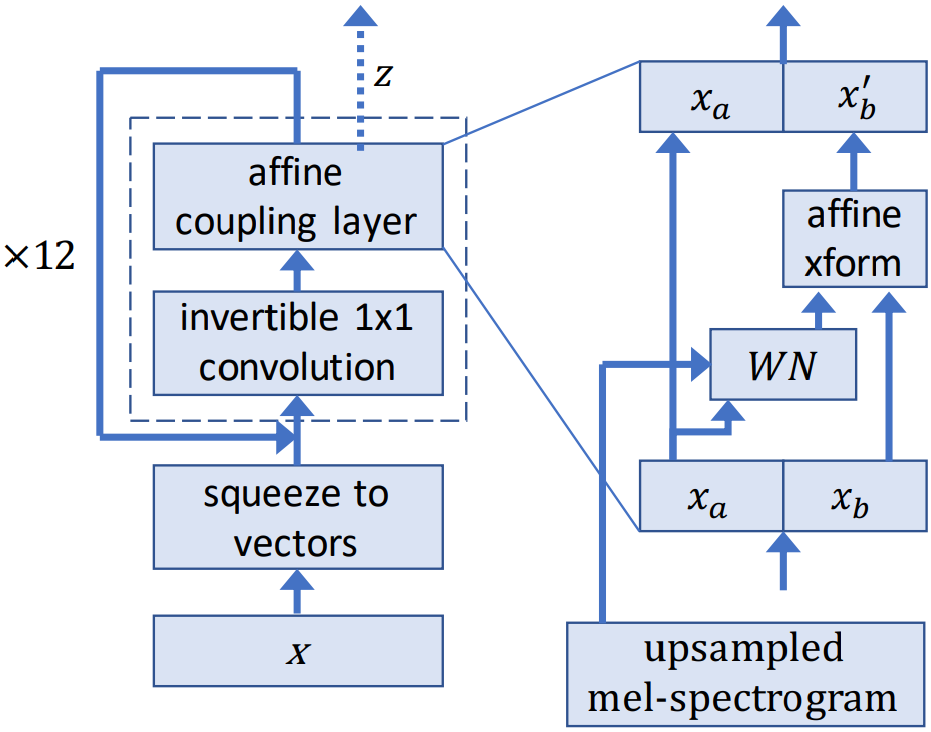

In [ ]:


class WaveGlow2(Model):
  def __init__(self, upsampled_size, n_channels,time=0):
    super(WaveGlow2, self).__init__()
    self.upsample = UpSampling1D(size=upsampled_size)



    self.invertible_conv = Conv1D(filters= n_channels, kernel_size =1 , use_bias = False)
    W,r  = tf.linalg.qr(tf.random.normal(shape=(n_channels,n_channels)))
    self.invertible_conv.set_weights = W
    self.n_channels = n_channels
    self.time = time
    self.wave_sequential_dil_x = Sequential()
    self.wave_sequential_conv_x = Sequential()

    self.wave_sequential_dil_mel = Sequential()
    self.wave_sequential_conv_mel = Sequential()

    self.LayerNorm_x = LayerNormalization()
    self.LayerNorm_mel = LayerNormalization()

    self.batch_norm = BatchNormalization()


    skip_fil = n_channels//2
    self.wave_skip_conv_1_x = Conv1D(filters = skip_fil, kernel_size = 1, activation = 'relu')
    self.wave_skip_conv_2_x = Conv1D(filters = skip_fil, kernel_size = 1)

    self.wave_skip_conv_1_mel = Conv1D(filters = skip_fil, kernel_size = 1, activation = 'relu')
    self.wave_skip_conv_2_mel = Conv1D(filters = skip_fil, kernel_size = 1)

    self.gated_activation = tf.keras.layers.Multiply()

  def upsampling(self, mel_spectrogram):
    #mel_spectrogram => (B,T,C)
    mel_spectrogram = tf.transpose(mel_spectrogram, perm=[0,2,1])
    upsampled_mel_spectrogram = self.upsample(mel_spectrogram)
    return upsampled_mel_spectrogram

  def Invertible_convolution(self, raw_audio_data, log_det_sum):


    #raw_audio_data = (1,58112) (B,T)
    if tf.rank(raw_audio_data) == 2:
      raw_audio_data= tf.expand_dims(raw_audio_data, axis = -1) # => (1,58112,1) (B,T,C)
      raw_audio_data = tf.tile(raw_audio_data, [1,1,self.n_channels])

    invertibled_audio = self.invertible_conv(raw_audio_data)
    #print(invertibled_audio.shape)
    B,T,C = invertibled_audio.shape
    W = tf.squeeze(self.invertible_conv.weights[0], axis = 0)

    det_W = tf.linalg.det(W)

    log_det_W = tf.math.log(tf.abs(det_W))

    log_det_W = log_det_W * B * T
    log_det_sum = log_det_sum + log_det_W
    return invertibled_audio, log_det_sum

  def Wavenet(self, x_a, upsampled_mel,n_layers,filter,time):
    dilation = 2
    if time==0:
      self.wave_sequential_dil_x.add(Input(shape=(x_a.shape)))
      self.wave_sequential_dil_mel.add(Input(shape=(upsampled_mel.shape)))
      self.wave_sequential_conv_x.add(Input(shape=(x_a.shape[0], x_a.shape[1], filter)))
      self.wave_sequential_conv_mel.add(Input(shape=(upsampled_mel.shape[0], upsampled_mel.shape[1], filter)))



    if len(self.wave_sequential_dil_x.layers) ==0:
      for i in range(n_layers):

        self.wave_sequential_dil_x.add(Conv1D(filters = filter,kernel_size = 31, dilation_rate = dilation ** 1
                                              ,use_bias=False,padding = 'same'))

        self.wave_sequential_conv_x.add(Conv1D(filters = filter, kernel_size = 31, use_bias = False,
                                               padding = 'same'))


      for i in range(n_layers):


        self.wave_sequential_dil_mel.add(Conv1D(filters = filter,kernel_size = 31, dilation_rate = dilation ** i,
                                                use_bias = False,padding = 'same'))

        self.wave_sequential_conv_mel.add(Conv1D(filters = filter, kernel_size = 31,use_bias = False,
                                                 padding = 'same'))

    output_list_x = [x_a]
    #print('layer의 길이:{},{}'.format(len(self.wave_sequential_dil_x.layers), len(self.wave_sequential_conv_mel.layers)))
    for i in range(n_layers):
      after_dil = self.wave_sequential_dil_x.layers[i](output_list_x[i])

      after_mul = self.gated_activation([tanh(after_dil), sigmoid(after_dil)])
      #after_mul 1,58112,4
      one_block_output = self.wave_sequential_conv_x.layers[i](after_mul)
      if i !=0:
        output = one_block_output + output_list_x[i]
      else:
        output = one_block_output
      output_list_x.append(output)

    output_list_mel = [upsampled_mel]
    for i in range(n_layers):

      after_dil = self.wave_sequential_dil_mel.layers[i](output_list_mel[i])


      after_mul = self.gated_activation([tanh(after_dil) , sigmoid(after_dil)])

      one_block_output = self.wave_sequential_conv_mel.layers[i](after_mul)

      if i !=0:
        output = one_block_output + output_list_mel[i]
      else:
        output = one_block_output

      output_list_mel.append(output)

    del output_list_x[0]
    del output_list_mel[0]
    skip_x = sum(output_list_x)

    skip_mel = sum(output_list_mel)


    skip_x_2 = relu(skip_x)

    skip_mel_2 = relu(skip_mel)

    skip_x_3 = self.wave_skip_conv_1_x(skip_x_2)

    skip_x_4 = self.wave_skip_conv_2_x(skip_x_3) + skip_x_3


    skip_mel_3 = self.wave_skip_conv_1_x(skip_mel_2)
    skip_mel_4 = self.wave_skip_conv_2_x(skip_mel_3) +skip_mel_3

    log_s = softmax(skip_x_4)
    t = softmax(skip_mel_4)

    return log_s, t

  def Affine(self, invertibled_audio,upsampled_mel,n_layer_wave, filter,log_det_sum,time):
    x_a, x_b = tf.split(invertibled_audio, num_or_size_splits=2, axis = -1)
    log_s, t = self.Wavenet(x_a, upsampled_mel, n_layer_wave, filter,time)
    x_b_prime = tf.multiply(tf.exp(log_s), x_b) + t + x_a
    output = tf.concat([x_a, x_b_prime], axis = -1)

    log_det_sum = log_det_sum + tf.reduce_sum(log_s)
    return output, log_det_sum
  def reverse_conv(self,z):
    W = tf.squeeze(self.invertible_layer.weights[0])
    W_inverse = tf.linalg.inv(W)

    x = tf.nn.conv1d(z,filters=W_inverse, stride= 1)
    return x
  def reverse_affine(self, z, c):
    z_a, z_b = tf.split(z, num_or_size_splits=2, axis = -1)
    log_s, t = self.Wavenet(z,c,None, None)
    z_b = tf.exp(-log_s) * (z_b - t)

    x = tf.catenate((z_a, z_b), dim=-1)

    return x, c

  def call(self, inputs):
    n_layers, n_layer_wave, filter = 4,12,4
    log_det_sum_conv, log_det_sum_affine = [0.0], [0.0]
    raw_audio_data, mel_spectrogram = inputs
    output_list = [raw_audio_data]
    upsampled_mel = self.upsampling(mel_spectrogram)
    #print('upsampled_mel.shape:{}'.format(upsampled_mel.shape))
    for i in range(n_layers):
      invertibled_audio, log_det_conv = self.Invertible_convolution(output_list[i], log_det_sum_conv[i])

      log_det_sum_conv.append(log_det_conv)
      output, log_det_affine = self.Affine(invertibled_audio, upsampled_mel,n_layer_wave, filter, log_det_sum_affine[i],self.time)
      log_det_sum_affine.append(log_det_affine)
      output_list.append(output)
      self.time = self.time + 1
    z = output_list[-1]
    value = z.shape[0] * z.shape[1] * z.shape[2]
    log_det_sum_affine = sum(log_det_sum_affine)
    log_det_sum_conv = sum(log_det_sum_conv)
    #print(log_det_sum_affine, log_det_sum_conv) #conv nan 값
    #log_det_sum = tf.reduce_sum(log_det_sum_conv) + tf.reduce_sum(log_det_sum_affine)
    log_det_sum =log_det_sum_affine + log_det_sum_conv
    #print('z.shape:{}'.format(z.shape))
    log_p = 0.5 * tf.reduce_sum((- tf.math.log(2.0 * math.pi) - z ** 2)) / value

    log_det = log_det_sum /  value

    log_p, log_det = tf.reduce_mean(log_p), tf.reduce_mean(log_det)

    loss =  - (log_p + log_det)
    return loss

model = WaveGlow2(128, 128)




optimizer = Adam(learning_rate = 1e-3)
train_dataset = tf.data.Dataset.from_tensor_slices((raw_audio_data, mel_spectrogram))
batch_size = 3
model.compile(optimizer=optimizer,loss = MeanSquaredError())
train_loader = train_dataset.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
epochs = 10

for epoch in range(epochs):
  print('Epoch:{}/{}'.format(epoch+1,epochs))
  for i, (raw_audio_data, mel_spectrogram) in enumerate(train_loader):
    with tf.GradientTape() as tape:

      loss = model(inputs=(raw_audio_data, mel_spectrogram))

      gradients = tape.gradient(loss, model.trainable_variables)
      clipped_gradients, _ = tf.clip_by_global_norm(gradients,clip_norm = 1.0)
      optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
    if i % 2 ==0:
      print('Loss:{:.3f}'.format(loss))
    i = i + 1











Epoch:1/10
Loss:5.892
Epoch:2/10
Loss:5.404
Epoch:3/10
Loss:5.119
Epoch:4/10
Loss:4.872
Epoch:5/10
Loss:4.648
Epoch:6/10
Loss:4.441
Epoch:7/10
Loss:4.246
Epoch:8/10
Loss:4.061
Epoch:9/10
Loss:3.885
Epoch:10/10
Loss:3.717


In [ ]:
#word_vec.shape:(3, 128, 512), mel_spectrogram.shape:(3, 128, 454), raw_audio_data.shape:(3, 58112)
class UpSampling(Model):
  def __init__(self):
    super(UpSampling,self).__init__()
    self.upsampling_layer = UpSampling1D(size = 16)


  def call(self,mel_spectrogram):
    mel_spectrogram = tf.transpose(mel_spectrogram, perm=[0,2,1])
    upsampled_mel_spectrogram = self.upsampling_layer(mel_spectrogram)
    return upsampled_mel_spectrogram
upsampling = UpSampling()
upsampled_mel_spectrogram = upsampling.call(mel_spectrogram)
print(upsampled_mel_spectrogram.shape)


(3, 7264, 128)


In [ ]:
class Invertible_Convolution(Model):
  def __init__(self,n_channels):
    super(Invertible_Convolution,self).__init__()
    self.invertible_layer = Conv1D(filters = n_channels, kernel_size=1, strides = 1, padding = 'valid', use_bias= False, dtype=tf.float32 )
    self.n_channels = tf.cast(n_channels, dtype = tf.int32)
    W,r  = tf.linalg.qr(tf.random.normal(shape=(n_channels, n_channels))) # W = orthonormal matrix
    self.invertible_layer.set_weights = W


  def squeeze_to_vector(self,raw_audio_data):
    if tf.rank(raw_audio_data) == 2:
      raw_audio_data= tf.expand_dims(raw_audio_data, axis = -1)

    if raw_audio_data.shape[1] < raw_audio_data.shape[2]:
      raw_audio_data = tf.transpose(raw_audio_data, perm=[0,2,1])

    temporal = int(raw_audio_data.shape[1]/self.n_channels)
    raw_audio_data = tf.reshape(raw_audio_data, [raw_audio_data.shape[0], temporal, self.n_channels])
    return raw_audio_data

  def call(self,inputs):
    raw_audio_data,log_det_sum = inputs
    raw_audio_data = self.squeeze_to_vector(raw_audio_data)
    invertibled_audio_data = self.invertible_layer(raw_audio_data)

    B, T, C = invertibled_audio_data.shape
    W = tf.squeeze(self.invertible_layer.weights[0])


    _,log_det_W = tf.linalg.slogdet(W)
    log_det_W = log_det_W * B * T
    log_det_sum = log_det_sum + log_det_W
    return invertibled_audio_data, log_det_sum

  def reverse(self,z):
    W = tf.squeeze(self.invertible_layer.weights[0])
    W_inverse = tf.linalg.inv(W)
    print(W_inverse.shape)
    x = tf.nn.conv1d(z,filters=W_inverse, stride= 1, padding = "VALID")
    return x



invertible_Convolution = Invertible_Convolution(8)


In [ ]:
class WaveNet(Model):
  def __init__(self,n_channels, skip_channels,n_layers):
    super(WaveNet, self).__init__()
    self.conv_dilation_layers = Sequential()
    self.conv_layers = Sequential()
    self.n_channels = n_channels


    self.n_layers = n_layers
    self.after_skip_connection_conv_1 = Conv1D(filters = skip_channels, kernel_size = 1, activation = 'relu')
    self.after_skip_connection_conv_2 = Conv1D(filters = skip_channels, kernel_size = 1)

    self.tan_conv = Conv1D(filters = n_channels, kernel_size =1)
    self.sigmoid_conv = Conv1D(filters = n_channels, kernel_size =1)

    dilation = 1
    for _ in range(n_layers):
      dilation = dilation * 2
      self.conv_dilation_layers.add(Conv1D(filters = self.n_channels, kernel_size=1,dilation_rate = dilation))
      self.conv_layers.add(Conv1D(filters = self.n_channels, kernel_size =1))

  def tanh_sigmoid_multiply(self,input):
    tan_input = self.tan_conv(input)
    sigmoid_input = self.sigmoid_conv(input)
    tanh_act = tanh(tan_input)
    sigmoid_act = sigmoid(sigmoid_input)
    return tf.multiply(tanh_act , sigmoid_act)

  def call(self,input):
    output_list = []
    for i in range(self.n_layers):
      if i==0:
        after_dilation = self.conv_dilation_layers.layers[i](input)
        after_multiply = self.tanh_sigmoid_multiply(after_dilation)
        output = self.conv_layers.layers[i](after_multiply)
        output = output + input
      else:
        after_dilation = self.conv_dilation_layers.layers[i](output_list[i-1])
        after_multiply = self.tanh_sigmoid_multiply(after_dilation)
        output = self.conv_layers.layers[i](after_multiply)
        output = output + output_list[i-1]


      output_list.append(output)

    output_sum = sum(output_list)
    after_skip_connection_1 = relu(output_sum)
    after_skip_connection_2 = self.after_skip_connection_conv_1(after_skip_connection_1)
    wavenet_output = self.after_skip_connection_conv_2(after_skip_connection_2)


    return wavenet_output

class Affine_coupling_layer(Model):
  def __init__(self):
    super(Affine_coupling_layer, self).__init__()
    self.WaveNet_1 = WaveNet(4,4,12)
    self.WaveNet_2 = WaveNet(128,4,12)
  def call(self,inputs):

    z_init, upsampled_mel_spectrogram,log_det_sum = inputs
    x_a, x_b = tf.split(z_init, 2, axis = -1)
    log_s, t = self.WaveNet_1.call(x_a), self.WaveNet_2.call(upsampled_mel_spectrogram)
    x_b_prime = tf.multiply(np.exp(log_s) , x_b) + t
    z = tf.concat([x_a, x_b_prime], axis = -1)

    log_det_sum = log_det_sum + tf.reduce_sum(log_s)
    return z, log_det_sum

  def reverse(self,z, c):
    z_a, z_b = tf.split(z, 2, axis = -1)
    log_s, t = self.WaveNet(z_a, c)
    x_b = tf.multiply((z_b-t) , np.exp(-1 * log_s))
    x = tf.concat([z_a, x_b], axis = -1)
    return x




class WaveGlow(Model):
  def __init__(self, n_layers):
    super(WaveGlow, self).__init__()
    self.n_layers = n_layers
    self.Invertible_Convolution = Invertible_Convolution(8)
    self.Affine_coupling_layer = Affine_coupling_layer()
    self.UpSampling = UpSampling()


  def call(self, inputs):
    log_conv_det_list = [0]
    log_affine_det_list = [0]
    mel_spectrogram, raw_audio_data = inputs
    upsampled_mel_spectrogram = self.UpSampling.call(mel_spectrogram)

    for i in range(self.n_layers):
      invertibled_audio_data, log_conv_det_sum = self.Invertible_Convolution.call([raw_audio_data, log_conv_det_list[i]])
      log_conv_det_list.append(log_conv_det_sum)
      z, log_affine_det_sum = self.Affine_coupling_layer.call([ invertibled_audio_data,upsampled_mel_spectrogram, log_affine_det_list[i]])
      log_affine_det_list.append(log_affine_det_sum)
    log_det_sum = sum(log_conv_det_list) + sum(log_affine_det_list)
    log_p = 0.5 * tf.reduce_sum((- np.log(2.0 * np.pi) - tf.math.square(z))) / (z.shape[0] * z.shape[1] * z.shape[2])
    log_det = log_det_sum /  (z.shape[0] * z.shape[1] * z.shape[2])
    return log_p, log_det




model = WaveGlow(12)



# 모델에 입력 데이터를 전달하여 사용

#model.build(input_shape=([mel_spectrogram.shape, raw_audio_data.shape]))






In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((mel_spectrogram, raw_audio_data))


batch_size = 1
shuffle_buffer_size = len(mel_spectrogram)
dataset = dataset.shuffle(shuffle_buffer_size)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


train_loader = iter(dataset)



In [ ]:
learning_rate = 1e-3
optimizer = Adam(learning_rate = learning_rate)

In [ ]:
def training(num_epochs, print_interval):
  for epoch in range(num_epochs):
    for step, (mel_spectrogram, raw_audio_data) in enumerate(train_loader):
      # 모델에 입력할 데이터를 텐서로 변환
      mel_spectrogram, raw_audio_data = tf.convert_to_tensor(mel_spectrogram), tf.convert_to_tensor(raw_audio_data)
      # 그래디언트 초기화
      with tf.GradientTape() as tape:
        log_p, log_det = model([mel_spectrogram, raw_audio_data])
        log_p, log_det = tf.reduce_mean(log_p), tf.reduce_mean(log_det)
        loss = -(log_p + log_det)

      # 그래디언트 계산
      gradients = tape.gradient(loss, model.trainable_variables)

      # 그래디언트 클리핑
      gradients, _ = tf.clip_by_global_norm(gradients, 1.0)

      # 파라미터 업데이트
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      if step % print_interval == 0:
          print("Epoch: {} Step: {} Loss: {:.4f}".format(epoch, step, loss.numpy()))
      print(step)


training(100,1)

ValueError: ignored

#Test

In [ ]:
wav_list = []
for i in os.listdir('wav_folder'):
  wav_list.append(i)
wav_file_path = os.path.join('wav_folder', wav_list[1])
data, sampling_rate = librosa.load(wav_file_path)
print(len(data), sampling_rate)

78087 22050


In [ ]:
ipd.Audio(data, rate= sampling_rate)

In [ ]:
data_resampled = librosa.resample(y = data, orig_sr=sampling_rate, target_sr=sampling_rate//4)

In [ ]:
print(len(data_resampled))

19520


In [ ]:
ipd.Audio(data_resampled, rate= sampling_rate//4)


In [ ]:
W = np.random.rand(128,128)
det_W = tf.linalg.det(W)
print(det_W)

tf.Tensor(-1.4760971400606334e+38, shape=(), dtype=float64)


In [ ]:
raw_audio_data_input = tf.keras.Input(shape=(58112,))
print(raw_audio_data_input.shape[0])
audio_test = tf.squeeze(raw_audio_data_input, axis =0)
print(len(raw_audio_data_input.shape))


None
2


#predict test

In [ ]:
class audio_data_preprocessing_transformed_predict():
  def m4a_to_wav(self, m4a_folder_name, wav_folder_name):
    dir_path = os.getcwd()
    m4a_folder_path = os.path.join(dir_path, m4a_folder_name)
    wav_folder_path = os.path.join(dir_path, wav_folder_name)

    for file_name in os.listdir(m4a_folder_path):
      file_path = os.path.join(m4a_folder_path, file_name)
      if os.path.isdir(file_path) != True:
        audio_m4a = AudioSegment.from_file(file_path, format='m4a')

        wav_file_path = os.path.join(wav_folder_name, file_name)
        audio_m4a.export(wav_file_path, format='wav')
      else:
        pass;
  def Mel_spectrogram(self,wav_folder_name, frame_length, frame_stride, n_mels):
    mel_spectrogram_list = []
    dir_name = os.getcwd()
    wav_folder_path = os.path.join(dir_name, wav_folder_name)
    for file_name in os.listdir(wav_folder_path):
      wav_file_path = os.path.join(wav_folder_path, file_name)
      if os.path.isdir(wav_file_path) != True:
        data, sampling_rate = librosa.load(wav_file_path)
        n_fft = int(round(sampling_rate * frame_length))
        stride = int(round(sampling_rate * frame_stride))
      else:
        pass;

      mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=n_fft,
                                                      hop_length = stride,n_mels = n_mels )
      mel_spectrogram_list.append(mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_list_pad(self,Mel_spectrogram_list, embedding_dim):
    length_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      #print(mel_spectrogram.shape)
      length_list.append(mel_spectrogram.shape[1])
    max_length = max(length_list)
    mel_spectrogram_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      if max_length > embedding_dim:

        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,max_length - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)
      else:
        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,embedding_dim - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_to_numpy(self,mel_spectrogram_list):
    n_of_mel_spectrogram = len(mel_spectrogram_list)
    mel_spectrogram_numpy = np.zeros((n_of_mel_spectrogram, mel_spectrogram_list[0].shape[0], mel_spectrogram_list[0].shape[1]))
    for i, mel_spectrogram in enumerate(mel_spectrogram_list):
      mel_spectrogram_numpy[i][:][:] = mel_spectrogram

    return mel_spectrogram_numpy

  def call(self,m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels, embedding_dim):

    self.m4a_to_wav(m4a_folder_name, wav_folder_name)
    mel_spectrogram_list = self.Mel_spectrogram(wav_folder_name, frame_length, frame_stride, n_mels)
    mel_spectrogram_list = self.mel_spectrogram_list_pad(mel_spectrogram_list, embedding_dim)
    mel_spectrogram = self.mel_spectrogram_to_numpy(mel_spectrogram_list)
    return mel_spectrogram


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/glow_model/waveglow_9', custom_objects={
    'Invertible_Convolution_3': Invertible_Convolution_3,
    'WaveNet_3': WaveNet_3,
    'Affine_Coupling_Layer': Affine_Coupling_Layer,
    'WaveGlow3': WaveGlow3
})

In [ ]:
audio_preprocessing_predict = audio_data_preprocessing_transformed_predict()
mel_spectrogram_test = audio_preprocessing_predict.call('m4a_folder', 'wav_folder', 0.025, 0.010, 80, 846)
#mel_sample = tf.tile(mel_spectrogram_test,[8,1,1])

<ipython-input-21-af4431281f99>:23: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(wav_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
raw_audio_data_test = raw_audio_preprocessing.call('wav_folder')

sampling_rate:2756


<ipython-input-28-f7f7d56f84f0>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(wav_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
mel_test = tf.tile(mel_spectrogram_test, [32,1,1])
raw_audio_test = tf.tile(raw_audio_data_test, [32,1])

print(mel_test.shape)
print(raw_audio_test.shape)

(32, 80, 846)
(32, 27072)


In [ ]:
loss, output= loaded_model((raw_audio_test,mel_test))

In [ ]:
print(output.shape)

(32, 3384, 8)


In [ ]:
output_refine = output[:1,:,:]
print(output_refine.shape)

(1, 3384, 8)


In [ ]:
mean = np.mean(output_refine)
stddev = np.std(output_refine)

In [ ]:
z = tf.random.normal(shape= output_refine.shape, mean=mean, stddev=stddev)

In [ ]:
audio_sample = loaded_model.reverse(z, mel_spectrogram_test)
sampling_rate = 2756

In [ ]:
print(audio_sample.shape)
final_audio = tf.reshape(audio_sample, [1,audio_sample.shape[1] * audio_sample.shape[2]])[0]
print(final_audio.shape)

(1, 3384, 8)
(27072,)


In [ ]:
ipd.Audio(final_audio, rate=3000)


In [ ]:
loaded_model.summary()

Model: "wave_glow3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling1d (UpSampling1D  multiple                 0         
 )                                                               
                                                                 
 invertible__convolution_3 (  multiple                 64        
 Invertible_Convolution_3)                                       
                                                                 
 invertible__convolution_3_1  multiple                 64        
  (Invertible_Convolution_3)                                     
                                                                 
 invertible__convolution_3_2  multiple                 64        
  (Invertible_Convolution_3)                                     
                                                                 
 invertible__convolution_3_3  multiple                 6

In [ ]:
ipd.Audio(raw_audio_data[0,:],rate =3000)

In [ ]:
raw_test = raw_audio_data[:1,:]
print(raw_test.shape)

(1, 27072)


In [ ]:
raw_1 = tf.reshape(raw_test,[1,3384,8])

In [ ]:
raw_2 = tf.reshape(raw_1,[1,27072])

In [ ]:
raw_3 = raw_2[0,:]
print(raw_3.shape)

(27072,)


In [ ]:
ipd.Audio(raw_3,rate=3000)

In [ ]:
import torch
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/nvidia/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [ ]:
print(mel_spectrogram.shape)
mel = torch.tensor(mel_spectrogram[:1,:,:], dtype=torch.float64)

(1206, 80, 949)


In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel)

RuntimeError: ignored